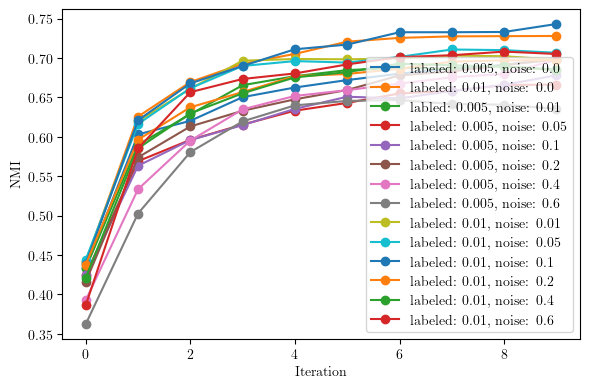

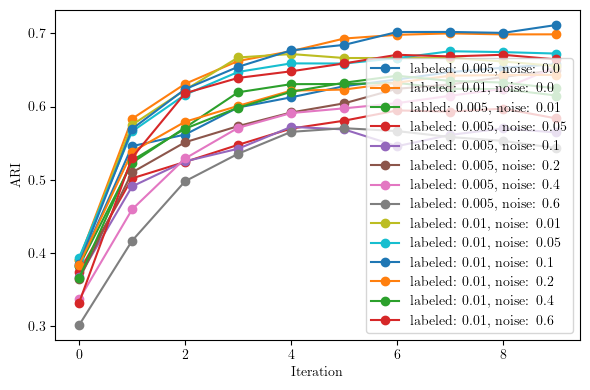

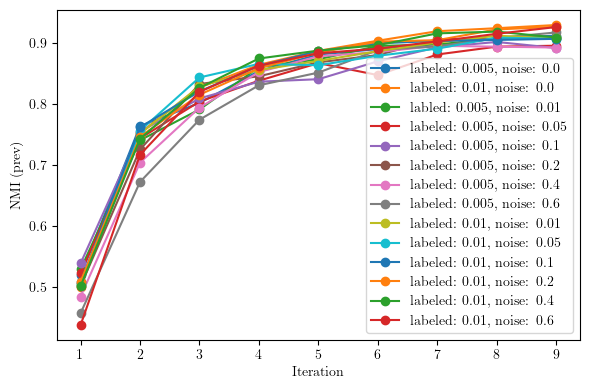

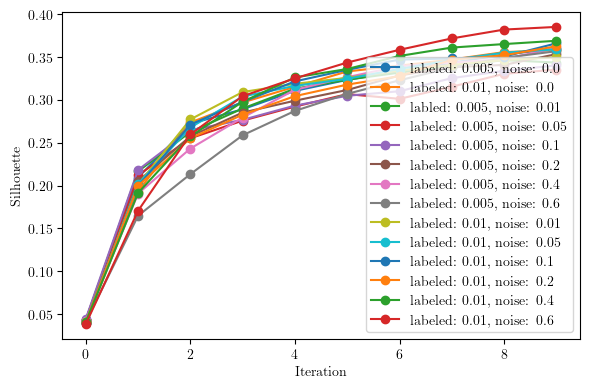

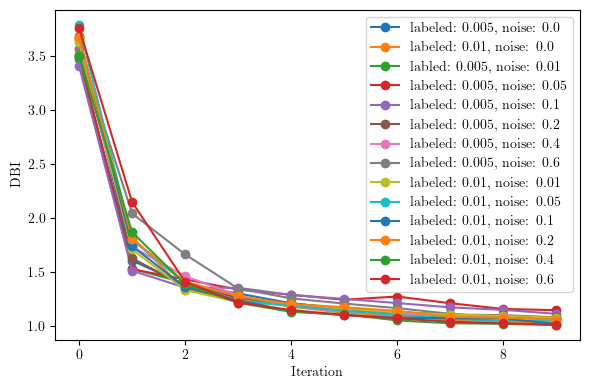

In [10]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Enable LaTeX font (optional)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

def load_metrics(run_paths):
    all_data = {}
    for run_name, run_path in run_paths.items():
        metrics_file = os.path.join(run_path, 'metrics.json')
        if os.path.isfile(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
            all_data[run_name] = metrics
    return all_data

# Suppose you have paths like:

# run_path = './experiments/run_noise_20250115_010746' # noise
run_path = './experiments/run_sparsity_20250115_001319' # overall sparsity
# run_path = './experiments/run_kmeans_iteration_variation_20250113_232436'
# run_path = './experiments/run_classwise_20250114_164435' # classwise

labels_noise = ['labeled: 0.005, noise: 0.0', 
            'labeled: 0.01, noise: 0.0', 
            'labled: 0.005, noise: 0.01',
            'labeled: 0.005, noise: 0.05',
            'labeled: 0.005, noise: 0.1',
            'labeled: 0.005, noise: 0.2',
            'labeled: 0.005, noise: 0.4',
            'labeled: 0.005, noise: 0.6',
            'labeled: 0.01, noise: 0.01',
            'labeled: 0.01, noise: 0.05',
            'labeled: 0.01, noise: 0.1',
            'labeled: 0.01, noise: 0.2',
            'labeled: 0.01, noise: 0.4',
            'labeled: 0.01, noise: 0.6',
        ]   

labels_overall_sparsity = ['0.0 \%',
            '0.05 \%',
            '0.1 \%',
            '0.2 \%',
            '0.5 \%',
            '1.0 \%'
]

labels_classwise = ['1 class, 0.1 \%',
                    '1 class, 1\%',
                    '2 classes, 0.1\%',
                    '2 classes, 1\%',
                    '5 classes, 0.1\%',
                    '5 classes, 1\%',
                    '8 classes, 0.1\%',
                    '8 classes, 1\%',
]

run_paths = {}
for i, label in enumerate(labels_noise):
    run_paths[label] = run_path + f'/config_{i+1}'

# run_paths = {
#     'labeled: 0.0': run_path + '/config_1',
#     'labeled: 0.0005': run_path + '/config_2',
#     'labeled: 0.001': run_path + '/config_3',
#     'labeled: 0.002': run_path + '/config_4',
#     'labeled: 0.005': run_path + '/config_5',
#     'labeled: 0.01': run_path + '/config_6',
# }

# run_paths = {
#     'baseline': run_path + '/config_1',
#     'labeled: 0.001, noise: 0.0': run_path + '/config_2',
#     'labeled: 0.01, noise: 0.0': run_path + '/config_3',
#     'labeled: 0.001, noise: 0.0': run_path + '/config_4',
#     'labeled: 0.01, noise: 0.1': run_path + '/config_5',
#     'labeled: 0.001, noise: 0.2': run_path + '/config_6',
# }
# run_paths = {
#     'labeled: 0.005, 5 iters pckmeans': run_path + '/config_1',
#     'labeled: 0.005, 10 iters pckmeans': run_path + '/config_2',
#     'labeled: 0.005, 20 iters pckmeans': run_path + '/config_3',
#     # 'labeled: 0.001': run_path + '/config_4',
#     # 'labeled: 0.002': run_path + '/config_5',
#     # 'labeled: 0.005': run_path + '/config_6',
#     # 'labeled: 0.01': run_path + '/config_7',
# }


metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'ari_true', 'nmi_prev', 'silhouette', 'dbi']
metrics_legend = {
    'nmi_true': 'NMI',
    'ari_true': 'ARI',
    'nmi_prev': 'NMI (prev)',
    'silhouette': 'Silhouette',
    'dbi': 'DBI',
}

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_noise[i], marker='o')
        i+=1
    
    # plt.title(f'{metrics_legend[metric]}')
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()

    # Save the plot in experiments folder as svg
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


    # break


# Noise Experiment Evaluation Plots

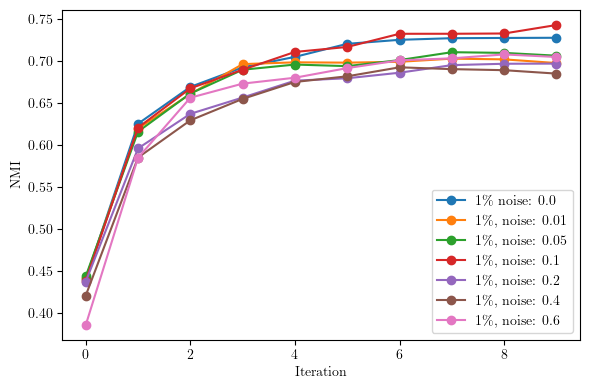

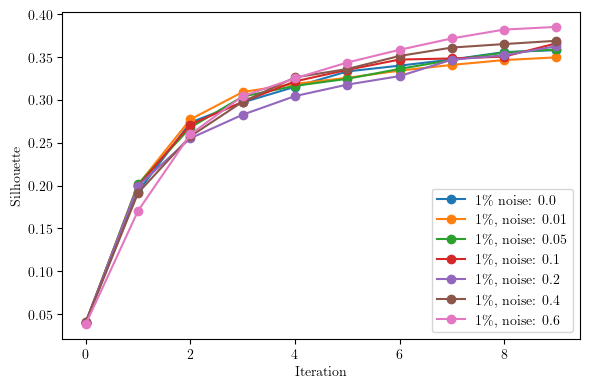

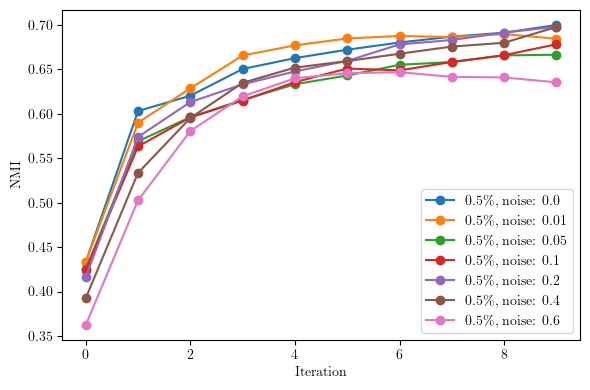

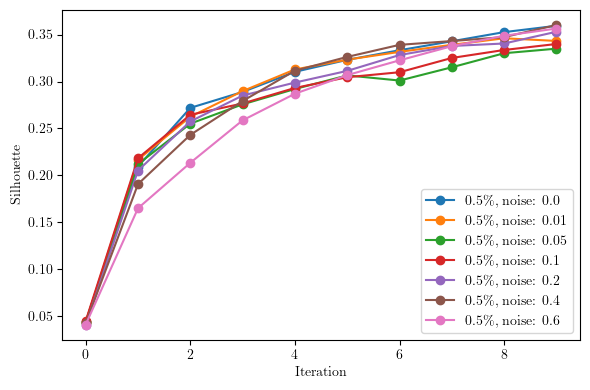

In [21]:


run_path = './experiments/run_noise_20250115_010746' # noise

labels_noise = ['0.5\%, noise: 0.0', 
                '1\% noise: 0.0', 
                '0.5\%, noise: 0.01',
                '0.5\%, noise: 0.05',
                '0.5\%, noise: 0.1',
                '0.5\%, noise: 0.2',
                '0.5\%, noise: 0.4',
                '0.5\%, noise: 0.6',
                '1\%, noise: 0.01',
                '1\%, noise: 0.05',
                '1\%, noise: 0.1',
                '1\%, noise: 0.2',
                '1\%, noise: 0.4',
                '1\%, noise: 0.6',
               ]  

indices_noise_1 = [2, 9, 10, 11, 12, 13, 14]

indices_noise_05 = [1, 3, 4, 5, 6, 7, 8]

# run_paths = {}
# for i, label in enumerate(labels_noise):
#     run_paths[label] = run_path + f'/config_{i+1}'
#     metrics_dict = load_metrics(run_paths)

run_paths_1 = {}
for i in indices_noise_1:
    run_paths_1[labels_noise[i-1]] = run_path + f'/config_{i}'
    metrics_dict_1 = load_metrics(run_paths_1)

run_paths_05 = {}
for i in indices_noise_05:
    run_paths_05[labels_noise[i-1]] = run_path + f'/config_{i}'
    metrics_dict_05 = load_metrics(run_paths_05)

# Collect metrics into DataFrames
dfs_1 = {}
for run_name, m in metrics_dict_1.items():
    dfs_1[run_name] = pd.DataFrame(m)

dfs_05 = {}
for run_name, m in metrics_dict_05.items():
    dfs_05[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']
metrics_legend = {
    'nmi_true': 'NMI',
    'silhouette': 'Silhouette',
}

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs_1.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_noise[indices_noise_1[i]-1], marker='o')
        i+=1
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs_05.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_noise[indices_noise_05[i]-1], marker='o')
        i+=1
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()

# Overall Sparsity Experiment Plots

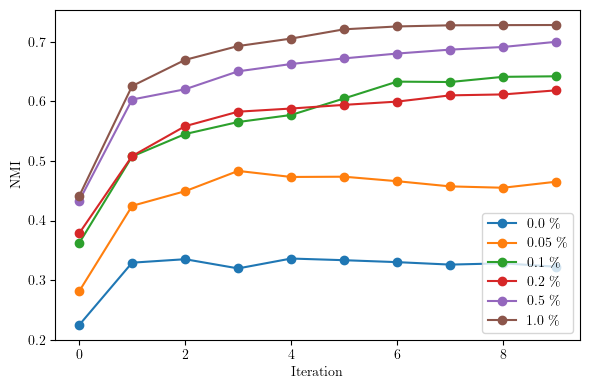

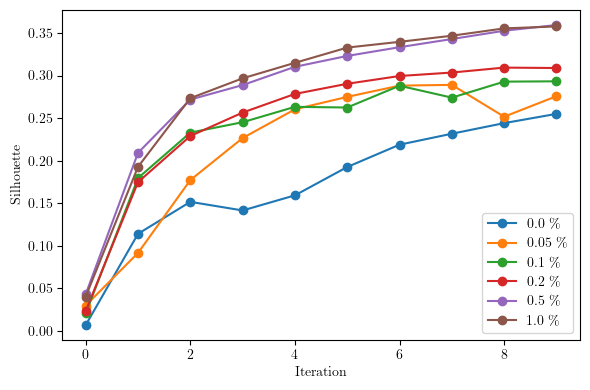

In [23]:
run_path = './experiments/run_sparsity_20250115_001319' # overall sparsity

labels_overall_sparsity = ['0.0 \%',
            '0.05 \%',
            '0.1 \%',
            '0.2 \%',
            '0.5 \%',
            '1.0 \%'
]

indices_overall_sparsity = [1, 2, 3, 4, 5, 6]

run_paths = {}
for i in indices_overall_sparsity:
    run_paths[labels_overall_sparsity[i-1]] = run_path + f'/config_{i}'
    metrics_dict = load_metrics(run_paths)

# Collect metrics into DataFrames
dfs = {}
for run_name, m in metrics_dict.items():
    dfs[run_name] = pd.DataFrame(m)

# The metrics we care about
metrics_to_plot = ['nmi_true', 'silhouette']

# %matplotlib qt
%matplotlib inline

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    # Plot this metric for each config/run
    i=0
    for run_name, df in dfs.items():
        # Some metrics might have NaN/null (e.g. 'nmi_prev' for iteration 0), so drop them or fill
        plt.plot(df[metric], label=labels_overall_sparsity[indices_overall_sparsity[i]-1], marker='o')
        i+=1
    plt.xlabel('Iteration')
    plt.ylabel(f'{metrics_legend[metric]}')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{run_path}/{metric}.pdf')
    plt.show()


In [49]:
# Compute the best metrics as before
best_metrics = {}

for run_name, df in dfs.items():
    best_nmi_true = df['nmi_true'].max()
    best_ari_true = df['ari_true'].max()
    best_silhouette = df['silhouette'].max()
    best_dbi = df['dbi'].min()  # lower is better
    
    best_metrics[run_name] = {
        'best_nmi_true': best_nmi_true,
        'best_ari_true': best_ari_true,
        'best_silhouette': best_silhouette,
        'best_dbi': best_dbi
    }

best_metrics_df = pd.DataFrame(best_metrics).T
print(best_metrics_df)

# Now plot this as a table in a figure
fig, ax = plt.subplots(figsize=(6, 2))  # adjust size as needed
ax.axis('off')  # no x or y axes

# Round the values for nicer display
table_vals = best_metrics_df.round(3).values

# Create the table
table = ax.table(
    cellText=table_vals,
    colLabels=best_metrics_df.columns,
    rowLabels=best_metrics_df.index,
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # enlarge the table if needed

plt.title('Best Metrics per Configuration', y=1.08)  # move the title up
plt.tight_layout()
plt.show()


                  best_nmi_true  best_ari_true  best_silhouette  best_dbi
1 class, 0.1 \%        0.452489       0.328942         0.263171  1.200134
1 class, 1\%           0.329880       0.221285         0.301019  0.982276
2 classes, 0.1\%       0.403663       0.240945         0.299019  1.130187
2 classes, 1\%         0.368719       0.233230         0.308681  1.067379
5 classes, 0.1\%       0.518428       0.384362         0.302059  1.137786
5 classes, 1\%         0.540345       0.359592         0.292571  1.124963
8 classes, 0.1\%       0.613169       0.500804         0.355533  1.051676
8 classes, 1\%         0.608732       0.509083         0.330972  1.097832


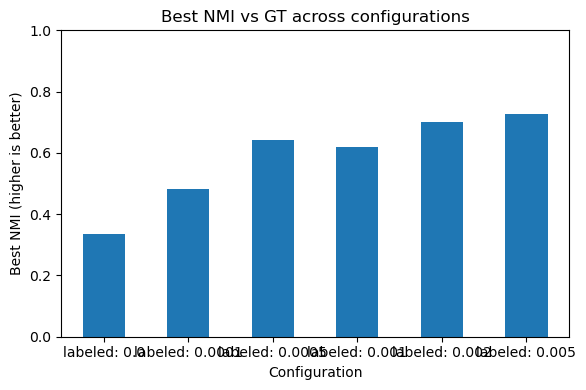

In [31]:
best_nmi_true_values = best_metrics_df['best_nmi_true']

plt.figure(figsize=(6, 4))
best_nmi_true_values.plot(kind='bar', rot=0)
plt.title('Best NMI vs GT across configurations')
plt.xlabel('Configuration')
plt.ylabel('Best NMI (higher is better)')
plt.ylim(0, 1)  # if you know the range is [0,1]
plt.tight_layout()
plt.show()


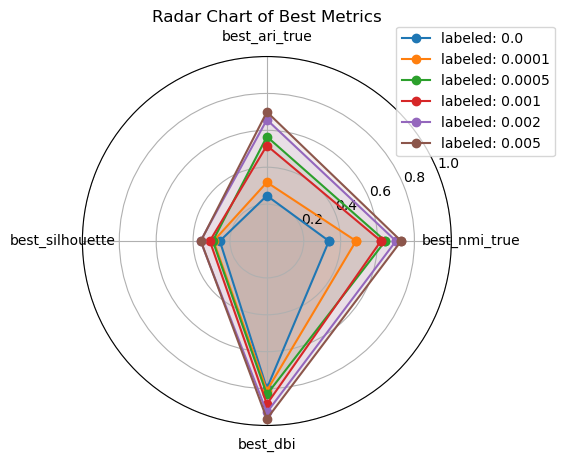

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we want to compare these metrics for each config
metrics_for_radar = ['best_nmi_true', 'best_ari_true', 'best_silhouette', 'best_dbi']

# Normalize or invert DBI so that "higher is better" for consistent plotting, e.g. 1 / DBI
radar_df = best_metrics_df.copy()
radar_df['best_dbi'] = 1 / radar_df['best_dbi']  # invert DBI

# Convert DataFrame to array
values = radar_df[metrics_for_radar].values
configs = radar_df.index

# Angles around the circle
num_metrics = len(metrics_for_radar)
angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False)

# Create subplots
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

for i, config in enumerate(configs):
    # each row in values corresponds to a single config
    stats = values[i]
    stats = np.concatenate((stats, [stats[0]]))  # repeat the first value to close the polygon
    angle_ext = np.concatenate((angles, [angles[0]]))

    ax.plot(angle_ext, stats, label=config, marker='o')
    ax.fill(angle_ext, stats, alpha=0.1)

ax.set_xticks(angles)
ax.set_xticklabels(metrics_for_radar)
ax.set_title('Radar Chart of Best Metrics')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
